**Goal**:
- Allow the spatial model to include local vaccinations
    - From the data
    - From a prediction into the future (many scenarios possible, but keep it simple). This is included in the `__call__` function of the `make_vaccination_function`, 
- Allow the model to include local measures (no priority)
- Allow the model to include local spread of VOCs (no priority)
- Main question: what is the distribution of hospitalisations in Belgium and how is this linked to the degree of vaccination?
- Side questions
    - How does the increase in Brussels affect the rest of the country?
    - How can this be alleviated with local measures? How is this different from national measures?
    - How can this be alleviated with isolation of Brussels?
    - How would the situation have been if Brussels was vaccinated as the rest-of-the-country average? And if Belgium was vaccinated as Brussels? 

**Remarks**

- Why are the vaccine-eligible subjects only those from class S and R? Would make sense to also include E and A
- Why do subjects from R become dS_v?
- `dD_v = (m_ICU/dICU_D)*ICU_v + (m_C/dc_D)*C_v` seems incomplete, unless the chance of dying once a subject is hospitalised is the same with or without vaccination. Not sure if there is data available on this.
- Note: `N_vacc` must be age and space stratified. It is not yet obvious how this is implemented into the main model (we'd have to dig deep into the code). The same problem goes with `Nc` if we are to stratify this spatially (per province).
- What type of vaccination does `get_public_spatial_vaccination_data` return? First vaccination, I suppose?
- `Nc` in params is no longer used
- Why don't we use CoMix data?

# Load packages and functions

In [7]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19model.models import models
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_contact_matrix_function, make_VOC_function, make_vaccination_function
from covid19model.models.utils import initial_state
# from covid19model.optimization.run_optimization import checkplots, calculate_R0
# from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
# from covid19model.optimization import pso, objective_fcns
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot, plot_fit, plot_calibration_fit
from covid19model.visualization.utils import moving_avg
from covid19model.optimization.utils import perturbate_PSO, run_MCMC
from covid19model.optimization.utils import samples_dict_to_emcee_chain # used for corner plots
import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Copied from mrollier-calibration-WAVE2_spatial.ipynb
import gc
import sys, getopt
import os
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

from covid19model.models import models
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters, VOC
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, make_VOC_function
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot
from covid19model.models.utils import initial_state


agg='prov'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
# Total population and contact matrices
Nc_dict = model_parameters.get_integrated_willem2012_interaction_matrices()

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Load and format national VOC data (for time-dependent VOC fraction)
df_VOC_abc = VOC.get_abc_data()
df_VOC_delta = VOC.get_delta_data()

# Load and format local vaccination data
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg=agg)

initN, Nc_dict, parameters = model_parameters.get_COVID19_SEIQRD_parameters(spatial=agg, vaccination=True, VOC=True)

values = 'hospitalised_IN'
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values=values, moving_avg=False)


### TIME-DEPENDENT FUNCTIONS ###
# Define time-dependent social contact matrix
contact_matrix_function = make_contact_matrix_function(df_google, Nc_dict)
ramp_fun = make_contact_matrix_function(df_google, Nc_dict).ramp_fun
# Covers the entire pandemic period

policies_WAVE2_no_relaxation = make_contact_matrix_function(df_google, Nc_dict).policies_WAVE2_no_relaxation
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_dict).policies_WAVE2_full_relaxation
policies_all = make_contact_matrix_function(df_google, Nc_dict).policies_all

# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# function to update VOC fraction
VOC_function = make_VOC_function(df_VOC_abc)

# function to update local vaccination level (first dose only)
vaccination_function = make_vaccination_function(public_spatial_vaccination_data, spatial=True)
sciensano_spatial_first_dose = vaccination_function.get_sciensano_spatial_first_dose

AttributeError: 'make_contact_matrix_function' object has no attribute 'policies_WAVE2_no_relaxation'

# Nice visualisation of VOC and their effect on infectivity

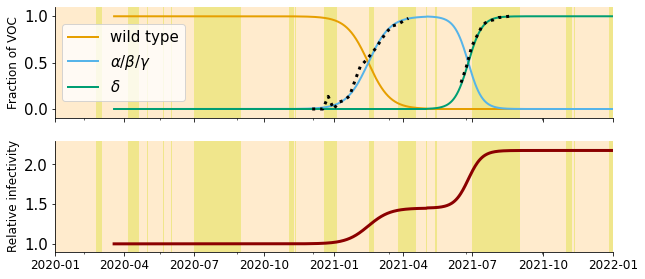

In [128]:

from covid19model.visualization.utils import moving_avg
from covid19model.visualization.output import *

# df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
sciensano_df_public = moving_avg(df_hosp[['H_in']].groupby('date').sum(), dropna=True)
sciensano_values_public = sciensano_df_public.values
sciensano_dates_public = sciensano_df_public.index + pd.Timedelta(hours=12)

VOC_function = make_VOC_function()
states = 0
param = 0


VOCs = np.zeros([len(sciensano_dates_public),3])
for i, t in enumerate(sciensano_dates_public):
    VOCs[i] = VOC_function(t, states, param)
    
start_date = datetime.datetime(2020, 1, 1, 0, 0)
end_date = datetime.datetime(2022, 1, 1, 0, 0)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=True)
ticklabelsize = 12
axs[0].grid(False)
axs[1].grid(False)
axs[0].set_xlim(start_date, end_date)
axs[1].set_xlim(start_date, end_date)
ylim=1.1
axs[0].set_ylim(-0.1, ylim)
axs[1].set_ylim(0.9, 2.3)
# Overlay hospitalisations
axs[0].plot(sciensano_dates_public, VOCs, linewidth=2, label=['wild type', '$\\alpha/\\beta/\\gamma$', '$\\delta$'])

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# ax.set_title('test', size=14)

df_VOC_abc[["baselinesurv_f_501Y.V1_501Y.V2_501Y.V3"]].plot(ax=axs[0], legend=False, linestyle='dotted', color='k')
df_VOC_delta.plot(ax=axs[0], legend=False, linestyle='dotted', color='k')
axs[0].set_xlabel(None, size=ticklabelsize)
axs[1].set_xlabel(None, size=ticklabelsize)
axs[0].set_ylabel('Fraction of VOC', size=ticklabelsize)
axs[1].set_ylabel('Relative infectivity', size=ticklabelsize)
plt.xticks(rotation=0, size=ticklabelsize)

K_inf = np.array([1, parameters['K_inf1'], parameters['K_inf2']])
K_eff = np.matmul(VOCs, K_inf)
axs[1].plot(sciensano_dates_public, K_eff, color='darkred')

axs[0].grid(False)

axs[0].legend(['wild type', '$\\alpha/\\beta/\\gamma$', '$\\delta$'], loc=6)
plt.savefig("VOC_prevalence", bbox_inches='tight', dpi=400)

# Nice visualisation of vaccination and their effect

In [307]:
df_B

,date,NIS,doses
605,2020-12-28,10000,0.0
606,2020-12-28,20001,0.0
607,2020-12-28,20002,0.0
608,2020-12-28,21000,0.0
609,2020-12-28,30000,0.0
...,...,...,...
1205,2022-01-10,50000,929755.0
1206,2022-01-10,60000,753686.0
1207,2022-01-10,70000,682364.0
1208,2022-01-10,80000,207227.0


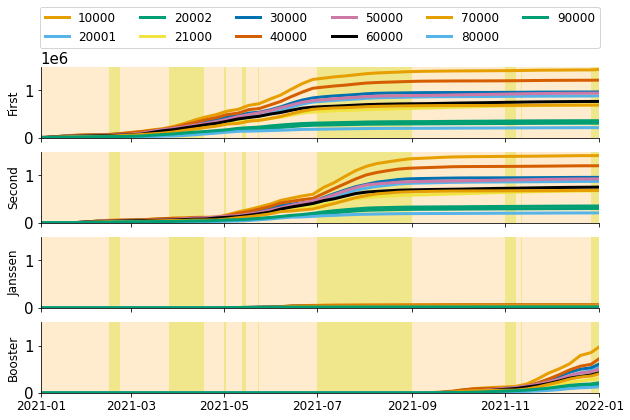

In [369]:
df = sciensano.get_public_spatial_vaccination_data(update=False,agg='prov')
# vaccination_function = make_vaccination_function(df['CUMULATIVE'])

df = vaccination_function.df.groupby(['dose', 'date', 'NIS']).sum()
df = df.reset_index()
df_A = df[df['dose']=='A'].drop(columns=['dose']).rename(columns={0:'doses'})
df_B = df[df['dose']=='B'].drop(columns=['dose']).rename(columns={0:'doses'})
df_C = df[df['dose']=='C'].drop(columns=['dose']).rename(columns={0:'doses'})
df_E = df[df['dose']=='E'].drop(columns=['dose']).rename(columns={0:'doses'})

df_A = pd.pivot_table(df_A, index=['date', 'NIS'], values='doses').unstack()
df_B = pd.pivot_table(df_B, index=['date', 'NIS'], values='doses').unstack()
df_C = pd.pivot_table(df_C, index=['date', 'NIS'], values='doses').unstack()
df_E = pd.pivot_table(df_E, index=['date', 'NIS'], values='doses').unstack()
# df_A.plot(kind='area', stacked=True, legend=True)

vacc_A = np.zeros([len(df_A.index),11])
vacc_B = np.zeros([len(df_B.index),11])
vacc_C = np.zeros([len(df_C.index),11])
vacc_E = np.zeros([len(df_E.index),11])
for i, t in enumerate(df_A.index):
    vacc_A[i] = df_A.values[i]
    vacc_B[i] = df_B.values[i]
    vacc_C[i] = df_C.values[i]
    vacc_E[i] = df_E.values[i]


start_date = datetime.datetime(2021, 1, 1, 0, 0)
end_date = datetime.datetime(2022, 1, 1, 0, 0)
    
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharex=True)
ticklabelsize = 12
axs[0].set_xlim(start_date, end_date)
axs[0].set_ylim(0, 1.5e6)
axs[1].set_ylim(0, 1.5)
axs[2].set_ylim(0, 1.5)
axs[3].set_ylim(0, 1.5)

axs[0].set_ylabel('First', size=ticklabelsize)
axs[1].set_ylabel('Second', size=ticklabelsize)
axs[2].set_ylabel('Janssen', size=ticklabelsize)
axs[3].set_ylabel('Booster', size=ticklabelsize)

# Overlay vaccinations
# ax.stackplot(df_A.index, vacc_A.T, labels=['wild type', '$\\alpha/\\beta/\\gamma$', '$\\delta$'])

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[2], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
color_timeframes(start_date, end_date, ax=axs[3], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)


# ax.stackplot(df_A.index, vacc_A.T, labels=['a', 'b'], alpha=0.8)
axs[0].plot(df_A.index, vacc_A)
axs[1].plot(df_B.index, vacc_B/1e6)
axs[2].plot(df_C.index, vacc_C/1e6)
axs[3].plot(df_E.index, vacc_E/1e6)

axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)
axs[3].grid(False)

plt.xticks(rotation=0, size=ticklabelsize)

axs[0].legend(df.groupby('NIS').sum().index.values, loc='center', bbox_to_anchor=(0.5, 1.55), ncol=6, fontsize=ticklabelsize)

# axs[0].set_title('test')

# plt.savefig('vaccination_timeseries.png', dpi=400, bbox_inches='tight')

In [338]:
df.groupby('NIS').sum().index.values

array([10000, 20001, 20002, 21000, 30000, 40000, 50000, 60000, 70000,
       80000, 90000], dtype=int64)

# Visualise raw vaccination data

Text(0, 0.5, 'First vaccination per age')

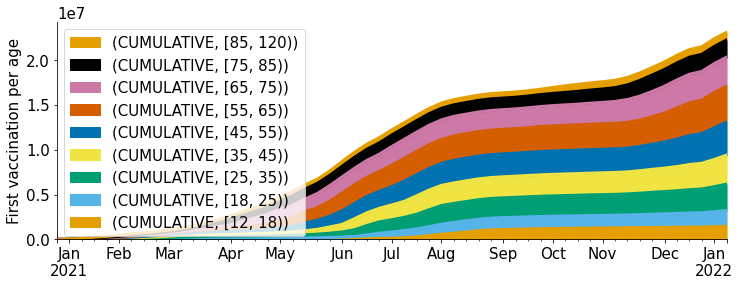

In [220]:
# Visualise vaccination data per age
fig, ax = plt.subplots(figsize=(12,4))
# public_spatial_vaccination_data[['CUMULATIVE']].groupby(['start_week', 'age']).sum().plot(ax=ax)

df = public_spatial_vaccination_data[['CUMULATIVE']].groupby(['date','age']).sum()
df.unstack().plot(kind='area', stacked=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')
ax.grid(False)
ax.set_xlabel(None)
ax.set_ylabel('First vaccination per age')

In [ ]:
# Visualise vaccination data per province
fig, ax = plt.subplots(figsize=(12,5))
# public_spatial_vaccination_data[['CUMULATIVE']].groupby(['start_week', 'age']).sum().plot(ax=ax)

df = public_spatial_vaccination_data[['CUMULATIVE']].groupby(['start_week','NIS']).sum()
df.unstack().plot(kind='area', stacked=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')
ax.grid(False)
ax.set_xlabel(None)
ax.set_ylabel('First vaccination per province')

# Visualise VOCs

In [ ]:
### EXTRA -- may delete ###

# ------------------
# Visualize variants
# ------------------

# Call VOC function and save data
dates = pd.date_range(start = '2020-09-01', end = '2021-09-01', freq='D')
wt=[]
alpha=[]
delta=[]
for date in dates:
    wt.append(VOC_function(date, {}, {})[0])
    alpha.append(VOC_function(date, {}, {})[1])
    delta.append(VOC_function(date, {}, {})[2])
        
# Make figure
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(dates,np.array(wt)*100, color='black')
ax.plot(dates,np.array(alpha)*100, color='red')
ax.plot(dates,np.array(delta)*100, color='green')
ax.set_ylabel('Prevalence of variant (%)')
ax.legend(['WT',r'alpha, beta, gamma','delta'], bbox_to_anchor=(.04, .5), loc='center left', fontsize=14)
ax.grid(False)

# plt.savefig('VOC_changes.png', dpi=400, bbox_inches='tight')

# Visualise processed vaccination data

Text(0.5, 1.0, 'First vaccination dose per age class')

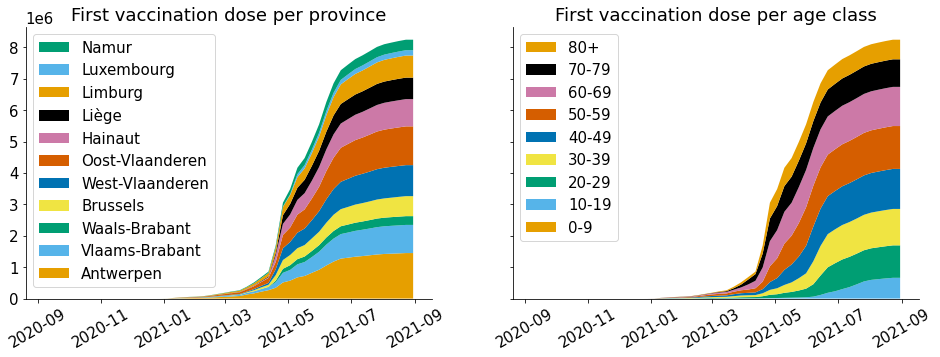

In [116]:
# Per province

dates_vacc = pd.date_range(start = '2020-09-01', end = '2021-09-01', freq='W-MON')
vaccs_prov=[]
for date in dates_vacc:
    vacc_prov = sciensano_spatial_first_dose(date).sum(axis=1)
    vaccs_prov.append(vacc_prov)
vaccs_prov=np.array(vaccs_prov).cumsum(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16,5), sharey=True)
axs[0].grid(False)
labels = ['Antwerpen', 'Vlaams-Brabant', 'Waals-Brabant', 'Brussels', 'West-Vlaanderen', 'Oost-Vlaanderen',\
          'Hainaut', 'Liège', 'Limburg', 'Luxembourg', 'Namur']
axs[0].stackplot(dates_vacc, vaccs_prov[:,0],\
             vaccs_prov[:,1],\
             vaccs_prov[:,2],\
             vaccs_prov[:,3],\
             vaccs_prov[:,4],\
             vaccs_prov[:,5],\
             vaccs_prov[:,6],\
             vaccs_prov[:,7],\
             vaccs_prov[:,8],\
             vaccs_prov[:,9],\
             vaccs_prov[:,10],\
             labels=labels)
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[::-1], labels[::-1], loc='upper left')
axs[0].tick_params('x', labelrotation=30)
axs[0].set_title('First vaccination dose per province')

# Per age

vaccs = []
for date in dates_vacc:
    vacc = sciensano_spatial_first_dose(date).sum(axis=0)
    vaccs.append(vacc)
vaccs=np.array(vaccs).cumsum(axis=0)

axs[1].grid(False)
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
axs[1].stackplot(dates_vacc, vaccs[:,0],\
             vaccs[:,1],\
             vaccs[:,2],\
             vaccs[:,3],\
             vaccs[:,4],\
             vaccs[:,5],\
             vaccs[:,6],\
             vaccs[:,7],\
             vaccs[:,8],\
             labels=labels)
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles[::-1], labels[::-1], loc='upper left')
axs[1].tick_params('x', labelrotation=30)
axs[1].set_title('First vaccination dose per age class')

# plt.savefig('vaccinations-per-province-and-age.png', dpi=400, bbox_inches='tight')

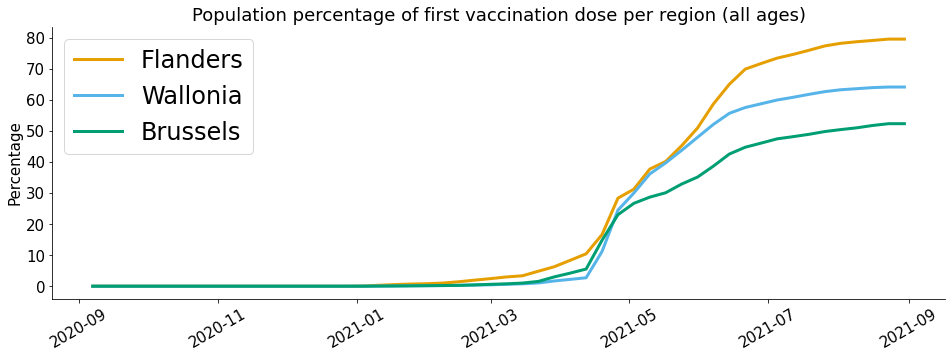

In [117]:
# Visualise vaccination degree per region (wallonia, Flanders, Brussels)

inhabitants = pd.read_csv('../../data/raw/GIS/inhabitants.csv')
pop_flanders = inhabitants[inhabitants['NIS']==2000]['inhabitants'].values[0]
pop_wallonia = inhabitants[inhabitants['NIS']==3000]['inhabitants'].values[0]
pop_brussels = inhabitants[inhabitants['NIS']==4000]['inhabitants'].values[0]

vaccs_flanders = vaccs_prov[:,0] + vaccs_prov[:,1] + vaccs_prov[:,4] + vaccs_prov[:,5] + vaccs_prov[:,8]
vaccs_wallonia = vaccs_prov[:,2] + vaccs_prov[:,6] + vaccs_prov[:,7] + vaccs_prov[:,9] + vaccs_prov[:,10]
vaccs_brussels = vaccs_prov[:,3]

rel_vaccs_flanders = (vaccs_flanders / pop_flanders)*100
rel_vaccs_wallonia = (vaccs_wallonia / pop_wallonia)*100
rel_vaccs_brussels = (vaccs_brussels / pop_brussels)*100

fig, ax = plt.subplots(figsize=(16,5))
ax.grid(False)
labels = ['Flanders', 'Wallonia', 'Brussels']
ax.plot(dates_vacc, rel_vaccs_flanders, label=labels[0])
ax.plot(dates_vacc, rel_vaccs_wallonia ,label=labels[1])
ax.plot(dates_vacc, rel_vaccs_brussels ,label=labels[2])
ax.legend(loc='upper left', fontsize=24)
ax.tick_params('x', labelrotation=30)
ax.set_title('Population percentage of first vaccination dose per region (all ages)')
ax.set_ylabel('Percentage')

plt.savefig('relative-vaccination-per-region.png', dpi=400, bbox_inches='tight')

# Visualise hospitalisations per province

Text(0.5, 0, '')

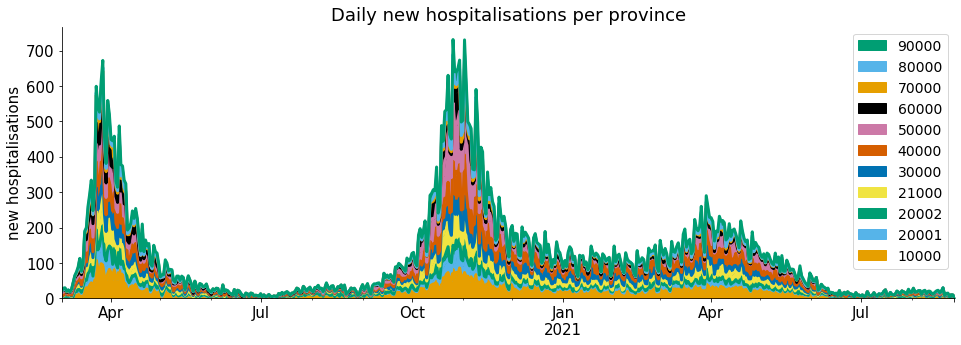

In [25]:
# Note that the final hospitalisation data lags behind the current date by about two weeks.

values = 'hospitalised_IN'
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values=values, moving_avg=False)

fig,ax=plt.subplots(figsize=(16,5))
df_sciensano.plot(kind='area', stacked=True,ax=ax)
ax.grid(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=14)
ax.set_title('Daily new hospitalisations per province')
ax.set_ylabel("new hospitalisations")
ax.set_xlabel(None)

# plt.savefig('daily-new-hospitalisations.png', dpi=400, bbox_inches='tight')

# Initialise model

In [51]:
# Model initial condition on August 27th

# Problem! These are the initial states for arrondissements.
# We are only interested in provinces for now, so we need to **aggregate**

##############################
# STARTING IN SEPTEMBER 2020 #
##############################

# partial

init_states_name = 'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_2020-08-27_full-manual-fix.json'
with open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{init_states_name}', 'r') as fp:
    initial_states = json.load(fp)

initial_states_prov_sept = dict()
for key in initial_states:
    initial_states_prov_sept[key] = np.zeros([11,9])
    initial_states_prov_sept[key][0] = np.array(initial_states[key][0:3]).sum(axis=0) # 1000 Antwerp
    initial_states_prov_sept[key][1] = np.array(initial_states[key][4:6]).sum(axis=0) # 20001 Vlaams-Brabant
    initial_states_prov_sept[key][2] = np.array(initial_states[key][6]) # 20002 Waals-Brabant
    initial_states_prov_sept[key][3] = np.array(initial_states[key][3]) # 21000 Brussel
    initial_states_prov_sept[key][4] = np.array(initial_states[key][7:15]).sum(axis=0) # 30000 West-Vlaanderen
    initial_states_prov_sept[key][5] = np.array(initial_states[key][15:21]).sum(axis=0) # 40000 Oost-Vlaanderen
    initial_states_prov_sept[key][6] = np.array(initial_states[key][21:28]).sum(axis=0) # 50000 Hainaut
    initial_states_prov_sept[key][7] = np.array(initial_states[key][28:33]).sum(axis=0) # 60000 Liege
    initial_states_prov_sept[key][8] = np.array(initial_states[key][33:36]).sum(axis=0) # 70000 Limburg
    initial_states_prov_sept[key][9] = np.array(initial_states[key][36:41]).sum(axis=0) # 80000 Luxembourg
    initial_states_prov_sept[key][10] = np.array(initial_states[key][41:]).sum(axis=0) # 90000 

# Add empty entries for vaccination states
vacc_states = ['S_v', 'E_v', 'I_v', 'A_v', 'M_v', 'C_v', 'C_icurec_v', 'ICU_v', 'R_v']
for state in vacc_states:
    initial_states_prov_sept[state]=np.zeros([11, 9])
    
    
##########################
# STARTING IN MARCH 2020 #
##########################

# complete

age=40
dist='frac'
init_number = 3 # if warmup = 54 and start_date = 2020-03-05
initE = initial_state(dist='frac', agg=agg, age=age, number=init_number) # 40-somethings dropped in Brussels (arrival by plane)
initial_states_prov_march = {'S': initN, 'E': initE}

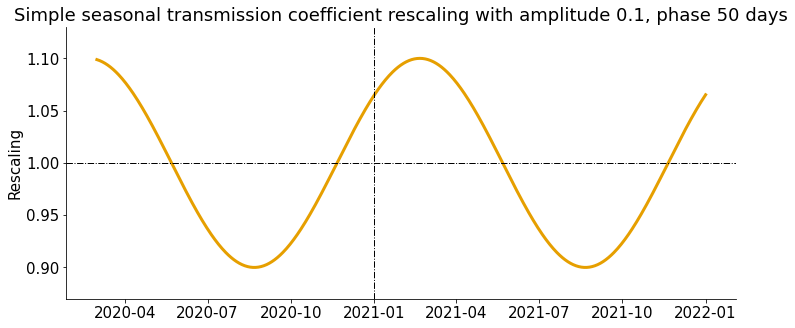

In [52]:
# Add definition of function that controls seasonality


dates = pd.date_range(start = '2020-03-01', end = '2022-01-01', freq='D')
ref_date = pd.to_datetime('2021-01-01')

# Note that this definition is different from Tijs's definition of seasonality
def seasonality(t, states, param, amplitude, peak_shift):
    # If peak_shift = 0, the max is on the first of January
    maxdate = pd.Timedelta(days=peak_shift) + ref_date
    # One period is one year long (seasonality)
    t = (t - pd.to_datetime(maxdate))/pd.Timedelta(days=1)/365
    return 1+amplitude*np.cos( 2*np.pi*(t))


season_effects = []
amplitude = 0.1
peak_shift = 50 # days
for date in dates:
    season_effect = seasonality(date, {}, {}, amplitude, peak_shift)
    season_effects.append(season_effect)
    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, season_effects)
ax.grid(False)
ax.set_ylim([0.87, 1.13])
ax.set_ylabel('Rescaling')
ax.axhline(1, color='k', linewidth=1, linestyle='-.')
ax.axvline(ref_date, color='k', linewidth=1, linestyle='-.')
title=ax.set_title(f'Simple seasonal transmission coefficient rescaling with amplitude {amplitude}, phase {peak_shift} days')

# plt.savefig('seasonal_transmission_rescaling.png', dpi=400, bbox_inches='tight')

In [53]:
# Model set-up

params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)
full_relaxation = False # relaxation is a thing of the past (pre-summer 2021)

# Time-dependent social contact: FULL RELAXATION
if full_relaxation:
    params.update({'l' : 5,
                   'l_relax' : 20,
                   'prev_schools' : 0,
                   'prev_work' : .5,
                   'prev_rest' : .5,
                   'prev_home' : .5,
                   'relaxdate' : '2021-06-01'}) # This is no longer very valid is it?
else:
    params.update({'l' : 5,
                   'prev_schools' : 0,
                   'prev_work' : .5,
                   'prev_rest_lockdown' : .5,
                   'prev_rest_relaxation' : .5,
                   'prev_home' : .5})
# time-dependent vaccination
params.update({'initN' : initN,
               'daily_first_dose' : 60000, # copy default values from vaccination_function, which are curently not used I think
               'delay_immunity' : 14,
               'vacc_order' : [8, 7, 6, 5, 4, 3, 2, 1, 0],
               'stop_idx' : 9,
               'refusal' : [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]})
# time-dependent seasonality
params.update({'season_factor' : 1})
params.update({'season_factor' : 1,
               'amplitude' : 0.1,
               'peak_shift' : 0})

# Update standard transmission coefficients
params.update({'beta_R' : 0.019,
               'beta_U' : 0.019,
               'beta_M' : 0.019})

model = models.COVID19_SEIRD_spatial_vacc(initial_states_prov_march, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policies_WAVE2_no_relaxation, 
                                                   'N_vacc' : vaccination_function, 
                                                   'alpha' : VOC_function, #})
                                                   'season_factor' : seasonality})

In [42]:
# -------------------
# Perform simulations
# -------------------

n_samples = 1
n_draws_per_sample = 1

warmup = 40 # 0
start_sim = '2020-03-05' # '2020-08-27' # Date of initial conditions
end_sim = '2022-01-01'

print('\n1) Simulating COVID-19 SEIRD '+str(n_samples)+' times')
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)


1) Simulating COVID-19 SEIRD 1 times


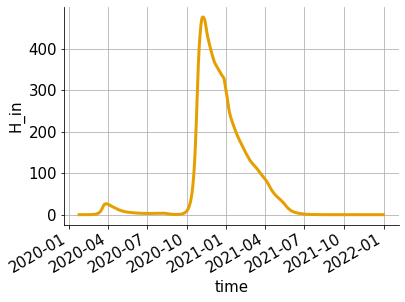

In [43]:
out['H_in'].sum(dim='place').sum(dim='Nc').plot()

Text(0, 0.5, 'H_in')

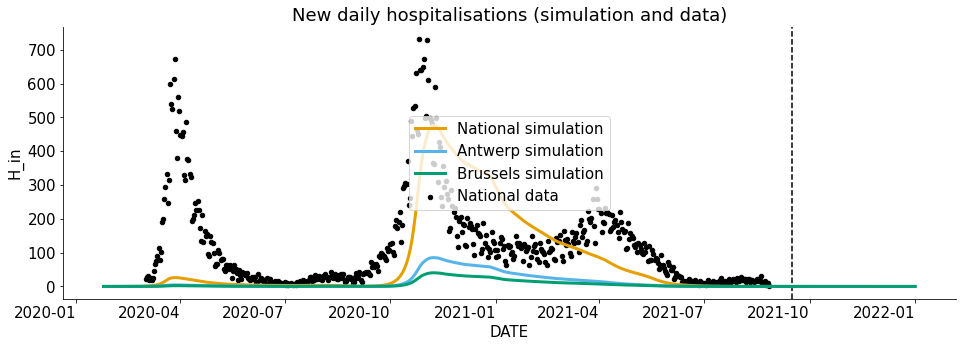

In [7]:
# Inspect output of single simulation pre-calibration

fig,ax=plt.subplots(figsize=(16,5))

today = pd.Timestamp.today()
ax.axvline(today, color='k', linestyle='--', linewidth=1.5)

comp = 'H_in'

out[comp].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='National simulation')
out[comp].sum(dim='Nc').sel(place=10000).plot(ax=ax, label='Antwerp simulation')
out[comp].sum(dim='Nc').sel(place=21000).plot(ax=ax, label='Brussels simulation')

# reset_index to make it into a DataFrame instead of a Series
df_sciensano.sum(axis=1).reset_index().plot(kind='scatter', x='DATE', y=0, ax=ax, label='National data', color='k', linewidth=1)

ax.set_title('New daily hospitalisations (simulation and data)')
ax.legend(loc='center')
ax.grid(False)
ax.set_ylabel(comp)

# Calibration

## Find warmup value

In [8]:
# ------------------
# Calibration set-up
# ------------------

# Start data of recalibration ramp
start_calibration = '2020-03-02' # first data available
# Last datapoint used to calibrate warmup and beta
# end_calibration = '2021-08-27' # last data available
end_calibration = '2020-03-21'

# Spatial unit: depends on aggregation
spatial_unit = f'{agg}_FULL-CALIBRATION'

# PSO settings
processes = 1 #int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()))
sys.stdout.flush()
multiplier = 10
maxiter = 100
popsize = multiplier*processes

# MCMC settings
max_n = 1000
print_n = 10

# Offset needed to deal with zeros in data in a Poisson distribution-based calibration
poisson_offset = 1

In [9]:
# -------------------------
# Print statement to stdout
# -------------------------

print('\n------------------------------------------')
print('PERFORMING CALIBRATION OF WARMUP and BETAs')
print('------------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')
sys.stdout.flush()


------------------------------------------
PERFORMING CALIBRATION OF WARMUP and BETAs
------------------------------------------

Using data from 2020-03-02 until 2020-03-21

1) Particle swarm optimization
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using 1 cores for a population of 10, for maximally 100 iterations.



In [10]:
# --------------
# define dataset
# --------------

# Only use hospitalisation data
data=[df_sciensano[start_calibration:end_calibration]]
states = ["H_in"]
weights = [1]

In [11]:
# CALIBRATION WITHOUT SEASONALITY. Takes a long time (at least 3 minutes per iteration at present). And it seems to get stuck :(

# -----------
# Perform PSO
# -----------

pars = ['warmup','beta_R', 'beta_U', 'beta_M']
bounds=((0.0,60.0),(0.005,0.060), (0.005,0.060), (0.005,0.060))

# run optimisation
theta = pso.fit_pso(model, data, pars, states, bounds, weights=weights, maxiter=maxiter, popsize=popsize, dist='poisson',
                    poisson_offset=poisson_offset, agg=agg, start_date=start_calibration, processes=processes)

# Assign estimate.
# warmup, pars_PSO = assign_PSO(model.parameters, pars, theta)
# model.parameters = pars_PSO

# Perform simulation with best-fit results
# out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# Print statement to stdout once
print(f'\nPSO RESULTS:')
print(f'------------')
print(f'warmup: {theta[0]}')
print(f'infectivities {pars[1:4]}: {theta[1:4]}.')
# print(f'seasonality {pars[4:6]}: {theta[4:6]}.')
sys.stdout.flush()

No constraints given.
Best after iteration 1: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 2: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 3: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 4: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 5: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 6: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 7: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 8: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 9: [3.26047427e+01 3.34683257e-02 1.95488779e-02 1.53065825e-02] -4008.5157196829978
Best after iteration 10:

Best after iteration 56: [3.65590702e+01 2.58574136e-02 2.06351671e-02 3.12219953e-02] -4427.952559652778
Best after iteration 57: [3.65590702e+01 2.58574136e-02 2.06351671e-02 3.12219953e-02] -4427.952559652778
New best for swarm at iteration 58: [3.67409777e+01 2.58359879e-02 2.06412055e-02 3.13660103e-02] -4428.383175713672
Best after iteration 58: [3.67409777e+01 2.58359879e-02 2.06412055e-02 3.13660103e-02] -4428.383175713672
New best for swarm at iteration 59: [3.71634705e+01 2.58945187e-02 2.05123511e-02 3.14245567e-02] -4428.491514288523
Best after iteration 59: [3.71634705e+01 2.58945187e-02 2.05123511e-02 3.14245567e-02] -4428.491514288523
New best for swarm at iteration 60: [3.72112929e+01 2.58265257e-02 2.06032349e-02 3.15080543e-02] -4428.53622245889
Best after iteration 60: [3.72112929e+01 2.58265257e-02 2.06032349e-02 3.15080543e-02] -4428.53622245889
Best after iteration 61: [3.72112929e+01 2.58265257e-02 2.06032349e-02 3.15080543e-02] -4428.53622245889
New best for swa

Best after iteration 97: [3.73948243e+01 2.56796642e-02 2.01880154e-02 3.21007836e-02] -4429.595492829861
New best for swarm at iteration 98: [3.74350294e+01 2.56773589e-02 2.01759413e-02 3.21266772e-02] -4429.618349061368
Best after iteration 98: [3.74350294e+01 2.56773589e-02 2.01759413e-02 3.21266772e-02] -4429.618349061368
New best for swarm at iteration 99: [3.74268418e+01 2.56618138e-02 2.01772342e-02 3.21478660e-02] -4429.635523596289
Best after iteration 99: [3.74268418e+01 2.56618138e-02 2.01772342e-02 3.21478660e-02] -4429.635523596289
New best for swarm at iteration 100: [3.74202918e+01 2.56493777e-02 2.01782685e-02 3.21648171e-02] -4429.646971012829
Best after iteration 100: [3.74202918e+01 2.56493777e-02 2.01782685e-02 3.21648171e-02] -4429.646971012829
Stopping search: maximum iterations reached --> 100

PSO RESULTS:
------------
warmup: 37.42029175043979
infectivities ['beta_R', 'beta_U', 'beta_M']: [0.02564938 0.02017827 0.03216482].


Warmup value: 37


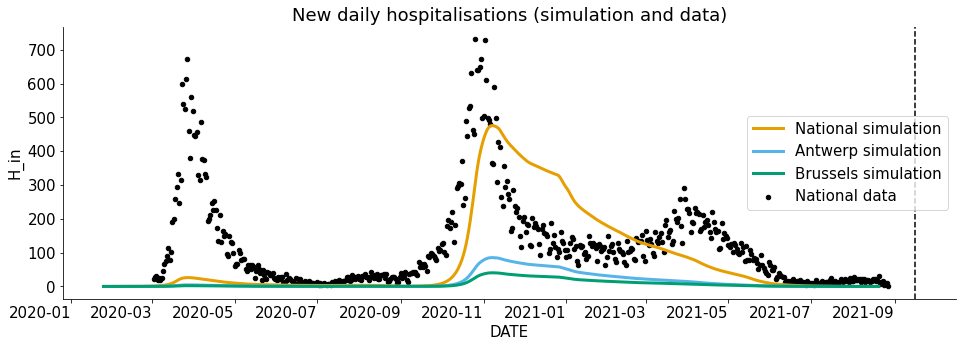

In [80]:
# plot result of best-fit

warmup = 37 #int(theta[0])
params.update({'beta_R' : 0.02564938, # theta[1], 
               'beta_U' : 0.02017827, # theta[2],
               'beta_M' : 0.03216482}) #theta[3]})

out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# Inspect output of single simulation pre-calibration

fig,ax=plt.subplots(figsize=(16,5))

today = pd.Timestamp.today()
ax.axvline(today, color='k', linestyle='--', linewidth=1.5)

comp = 'H_in'

out[comp].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='National simulation')
out[comp].sum(dim='Nc').sel(place=10000).plot(ax=ax, label='Antwerp simulation')
out[comp].sum(dim='Nc').sel(place=21000).plot(ax=ax, label='Brussels simulation')

# reset_index to make it into a DataFrame instead of a Series
df_sciensano.sum(axis=1).reset_index().plot(kind='scatter', x='DATE', y=0, ax=ax, label='National data', color='k', linewidth=1)

ax.set_title('New daily hospitalisations (simulation and data)')
ax.legend(loc='center right')
ax.grid(False)
ax.set_ylabel(comp)

print(f"================")
print(f"Warmup value: {int(warmup)}")
print(f"================")

## Find all other values

In [27]:
# ------------------
# Calibration set-up
# ------------------

# Start data of recalibration ramp
start_calibration = '2020-03-02' # first data available
# Last datapoint used to calibrate warmup and beta
end_calibration = '2021-08-20' # last data available minus one week (bad data)

# Spatial unit: depends on aggregation
spatial_unit = f'{agg}_FULL-CALIBRATION'

# PSO settings
processes = 1 #int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()))
sys.stdout.flush()
multiplier = 10
maxiter = 100
popsize = multiplier*processes

# MCMC settings
max_n = 1000
print_n = 10

# Offset needed to deal with zeros in data in a Poisson distribution-based calibration
poisson_offset = 1

In [28]:
# -------------------------
# Print statement to stdout
# -------------------------

print('\n-----------------------------------------------')
print('PERFORMING CALIBRATION OF BETAs, and ALL THE REST')
print('-------------------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')
sys.stdout.flush()


-----------------------------------------------
PERFORMING CALIBRATION OF BETAs, and ALL THE REST
-------------------------------------------------

Using data from 2020-03-02 until 2021-08-20

1) Particle swarm optimization
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using 1 cores for a population of 10, for maximally 100 iterations.



In [31]:
# --------------
# define dataset
# --------------

# Only use hospitalisation data
data=[df_sciensano[start_calibration:end_calibration]]
states = ["H_in"]
weights = [1]

In [32]:
# CALIBRATION WITHOUT SEASONALITY. Takes a long time (at least 3 minutes per iteration at present). And it seems to get stuck :(

# -----------
# Perform PSO
# -----------

warmup = 37
pars = ['beta_R',     'beta_U',      'beta_M',      'l',    'prev_schools', 'prev_work', 'prev_rest_lockdown', 'prev_rest_relaxation', 'prev_home', 'K_inf1',  'K_inf2',  'amplitude', 'peak_shift']
bounds=((0.005,0.040),(0.005,0.040), (0.005,0.040), (4,14), (0.15,0.95),    (0.05,0.95), (0.05,0.95),          (0.05,0.95),            (0.05,0.95), (1.4,1.6), (2.1,2.4), (0,0.30),    (-31, 31))

# run optimisation
theta = pso.fit_pso(model, data, pars, states, bounds, weights=weights, maxiter=maxiter, popsize=popsize, dist='poisson',
                    poisson_offset=poisson_offset, agg=agg, start_date=start_calibration, processes=processes,warmup=warmup)

# Assign estimate.
# warmup, pars_PSO = assign_PSO(model.parameters, pars, theta)
# model.parameters = pars_PSO

# Perform simulation with best-fit results
# out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

No constraints given.


c:\users\mrollier\documents\github\covid19-model\src\covid19model\optimization\objective_fcns.py:200: RuntimeWarning: invalid value encountered in log
  ll = - np.sum(ymodel+offset_value) + np.sum(np.log(ymodel+offset_value)*(ydata+offset_value))


New best for swarm at iteration 1: [ 2.03219649e-02  3.19888601e-02  5.00000000e-03  4.00000000e+00
  1.51765533e-01  5.00000000e-02  7.65276629e-01  5.00000000e-02
  5.00000000e-02  1.40000000e+00  2.10000000e+00  3.00000000e-01
 -3.10000000e+01] -97970.57054419402
Best after iteration 1: [ 2.03219649e-02  3.19888601e-02  5.00000000e-03  4.00000000e+00
  1.51765533e-01  5.00000000e-02  7.65276629e-01  5.00000000e-02
  5.00000000e-02  1.40000000e+00  2.10000000e+00  3.00000000e-01
 -3.10000000e+01] -97970.57054419402
Best after iteration 2: [ 2.03219649e-02  3.19888601e-02  5.00000000e-03  4.00000000e+00
  1.51765533e-01  5.00000000e-02  7.65276629e-01  5.00000000e-02
  5.00000000e-02  1.40000000e+00  2.10000000e+00  3.00000000e-01
 -3.10000000e+01] -97970.57054419402
New best for swarm at iteration 3: [ 1.27319988e-02  2.75091875e-02  3.10414803e-02  4.00000000e+00
  1.50000000e-01  1.83980282e-01  7.93455441e-01  5.00000000e-02
  5.00000000e-02  1.40000000e+00  2.10000000e+00  3.0000

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\models.py:1162: RuntimeWarning: divide by zero encountered in true_divide
  dS  = -dS_inf + zeta*R - e_a_eff*N_vacc/VE*S + (1/d_vacc)*(S_v + R_v)
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\models.py:1171: RuntimeWarning: divide by zero encountered in true_divide
  dR  = A/da + ((1-h)/dm)*M + (1-m_C)*C*(1/dc_R) + C_icurec*(1/dICUrec) - zeta*R - e_a_eff*N_vacc/VE*R # Recovered subjects enter from 4 compartments


New best for swarm at iteration 18: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 18: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 19: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 20: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 21: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.2165247

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\models.py:1053: RuntimeWarning: invalid value encountered in add
  + S_v + E_v + I_v + A_v + M_v + C_v + C_icurec_v + ICU_v + R_v
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\models.py:1058: RuntimeWarning: invalid value encountered in add
  VE = S + R


Best after iteration 50: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 51: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 52: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 53: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 54: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343

Best after iteration 90: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 91: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 92: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 93: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343024] -10095896.944792865
Best after iteration 94: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
 -8.09343

In [62]:
theta

array([ 0.02300276,  0.02245577,  0.03528301,  4.        ,  0.21716355,
        0.17985659,  0.64648914,  0.16089882,  0.05      ,  1.4       ,
        2.15250555,  0.21652476, -8.09343024])

Text(0, 0.5, 'H_in')

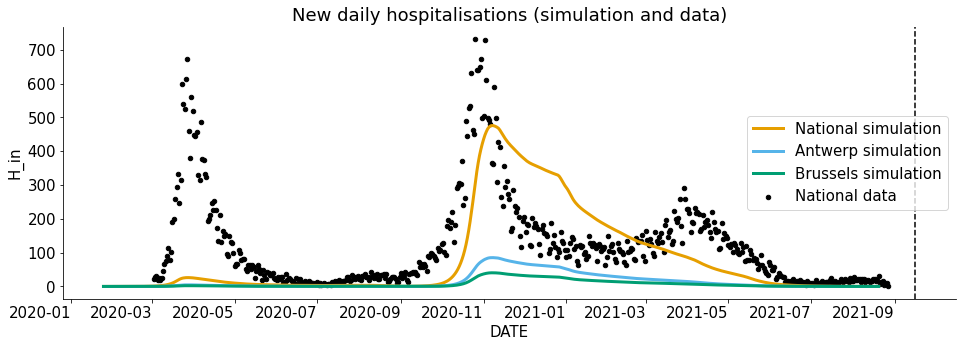

In [81]:
# Best after iteration 100: [ 0.02300276  0.02245577  0.03528301  4.          0.21716355  0.17985659
#  0.64648914  0.16089882  0.05        1.4         2.15250555  0.21652476
# -8.09343024] -10095896.944792865

# plot result of best-fit



for i in range(len(pars)):
    params.update({pars[i] : theta[i]})

# Start data of recalibration ramp
start_calibration = '2020-03-02' # first data available
# Last datapoint used to calibrate warmup and beta
end_calibration = '2021-08-20' # last data available minus one week (bad data)
warmup=37
out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# Inspect output of single simulation pre-calibration

fig,ax=plt.subplots(figsize=(16,5))

today = pd.Timestamp.today()
ax.axvline(today, color='k', linestyle='--', linewidth=1.5)

comp = 'H_in'

out[comp].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='National simulation')
out[comp].sum(dim='Nc').sel(place=10000).plot(ax=ax, label='Antwerp simulation')
out[comp].sum(dim='Nc').sel(place=21000).plot(ax=ax, label='Brussels simulation')

# reset_index to make it into a DataFrame instead of a Series
df_sciensano.sum(axis=1).reset_index().plot(kind='scatter', x='DATE', y=0, ax=ax, label='National data', color='k', linewidth=1)

ax.set_title('New daily hospitalisations (simulation and data)')
ax.legend(loc='center right')
ax.grid(False)
ax.set_ylabel(comp)

# plt.savefig('bad-PSO.png', dpi=400, bbox_inches='tight')

Text(0, 0.5, 'H_in')

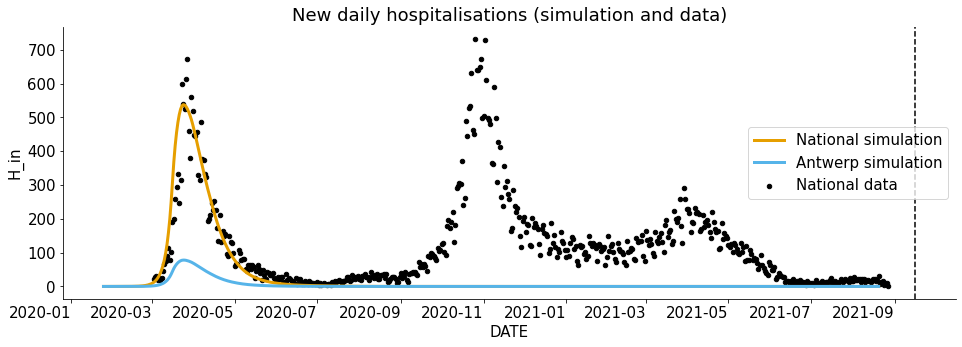

In [69]:
## Tweaking of results

for i in range(len(pars)):
    params.update({pars[i] : theta[i]})
    
params.pop('l1')
params.pop('l2')

if 'l' in params.keys():
    params.pop('l')
params.update({'l1' : 3.5,
               'l2' : 6.0})

model = models.COVID19_SEIRD_spatial_vacc(initial_states_prov_march, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policies_all, 
                                                   'N_vacc' : vaccination_function, 
                                                   'alpha' : VOC_function, #})
                                                   'season_factor' : seasonality})

out = model.sim(end_calibration,start_date=start_calibration,warmup=warmup)

# Inspect output of single simulation pre-calibration

fig,ax=plt.subplots(figsize=(16,5))

today = pd.Timestamp.today()
ax.axvline(today, color='k', linestyle='--', linewidth=1.5)

comp = 'H_in'

out[comp].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='National simulation')
out[comp].sum(dim='Nc').sel(place=10000).plot(ax=ax, label='Antwerp simulation')
# out[comp].sum(dim='Nc').sel(place=21000).plot(ax=ax, label='Brussels simulation')

# reset_index to make it into a DataFrame instead of a Series
df_sciensano.sum(axis=1).reset_index().plot(kind='scatter', x='DATE', y=0, ax=ax, label='National data', color='k', linewidth=1)

ax.set_title('New daily hospitalisations (simulation and data)')
ax.legend(loc='center right')
ax.grid(False)
ax.set_ylabel(comp)

# plt.savefig('bad-PSO.png', dpi=400, bbox_inches='tight')

## MCMC

# Prediction

## Proof of concept

In [96]:
# Model initial condition on August 27th

# Problem! These are the initial states for arrondissements.
# We are only interested in provinces for now, so we need to **aggregate**

##############################
# STARTING IN SEPTEMBER 2020 #
##############################

# partial

init_states_name = 'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_2020-08-27_full-manual-fix.json'
with open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{init_states_name}', 'r') as fp:
    initial_states = json.load(fp)

initial_states_prov_sept = dict()
for key in initial_states:
    initial_states_prov_sept[key] = np.zeros([11,9])
    initial_states_prov_sept[key][0] = np.array(initial_states[key][0:3]).sum(axis=0) # 10000 Antwerp
    initial_states_prov_sept[key][1] = np.array(initial_states[key][4:6]).sum(axis=0) # 20001 Vlaams-Brabant
    initial_states_prov_sept[key][2] = np.array(initial_states[key][6]) # 20002 Waals-Brabant
    initial_states_prov_sept[key][3] = np.array(initial_states[key][3]) # 21000 Brussel
    initial_states_prov_sept[key][4] = np.array(initial_states[key][7:15]).sum(axis=0) # 30000 West-Vlaanderen
    initial_states_prov_sept[key][5] = np.array(initial_states[key][15:21]).sum(axis=0) # 40000 Oost-Vlaanderen
    initial_states_prov_sept[key][6] = np.array(initial_states[key][21:28]).sum(axis=0) # 50000 Hainaut
    initial_states_prov_sept[key][7] = np.array(initial_states[key][28:33]).sum(axis=0) # 60000 Liege
    initial_states_prov_sept[key][8] = np.array(initial_states[key][33:36]).sum(axis=0) # 70000 Limburg
    initial_states_prov_sept[key][9] = np.array(initial_states[key][36:41]).sum(axis=0) # 80000 Luxembourg
    initial_states_prov_sept[key][10] = np.array(initial_states[key][41:]).sum(axis=0) # 90000 

# Add empty entries for vaccination states
vacc_states = ['S_v', 'E_v', 'I_v', 'A_v', 'M_v', 'C_v', 'C_icurec_v', 'ICU_v', 'R_v']
for state in vacc_states:
    initial_states_prov_sept[state]=np.zeros([11, 9])

In [98]:
policies_all?

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:264: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_start = pd.Timestamp(df['INCIDENCE'].ne(0).idxmax()[0], freq='D')
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:265: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_end = pd.Timestamp(df.index[-1][0], freq='D')


Text(0, 0.5, 'Percentage')

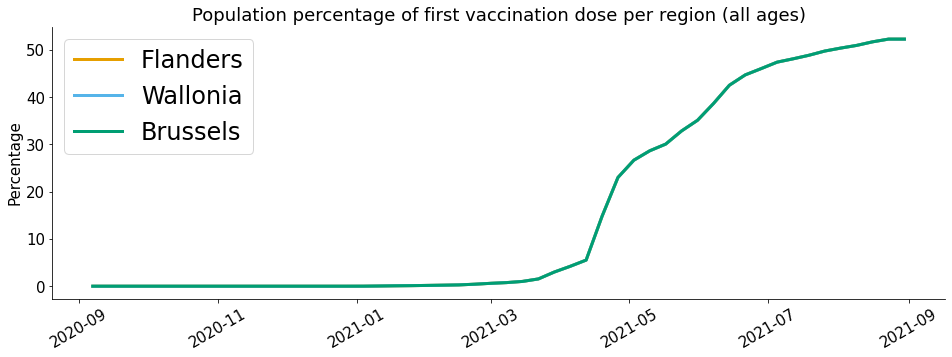

In [163]:
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg=agg)

inhabitants = pd.read_csv('../../data/raw/GIS/inhabitants.csv')
pop_flanders = inhabitants[inhabitants['NIS']==2000]['inhabitants'].values[0]
pop_wallonia = inhabitants[inhabitants['NIS']==3000]['inhabitants'].values[0]
pop_brussels = inhabitants[inhabitants['NIS']==4000]['inhabitants'].values[0]

public_spatial_vaccination_data_like_bxl = public_spatial_vaccination_data.copy()
for type_of_data in ['CUMULATIVE', 'INCIDENCE']:
    for nis in [10000, 20001, 20002, 21000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]:
        public_spatial_vaccination_data_like_bxl[type_of_data].loc[:,nis,:] = \
            public_spatial_vaccination_data[type_of_data].loc[:,21000,:].values / \
            inhabitants[inhabitants['NIS']==21000]['inhabitants'].values[0] * \
            inhabitants[inhabitants['NIS']==nis]['inhabitants'].values[0]

dates_vacc = pd.date_range(start = '2020-09-01', end = '2021-09-01', freq='W-MON')
vaccs_prov=[]

vaccination_function = make_vaccination_function(public_spatial_vaccination_data_like_bxl, spatial=True)
sciensano_spatial_first_dose = vaccination_function.get_sciensano_spatial_first_dose
for date in dates_vacc:
    vacc_prov = sciensano_spatial_first_dose(date).sum(axis=1)
    vaccs_prov.append(vacc_prov)
vaccs_prov=np.array(vaccs_prov).cumsum(axis=0)

# Visualise vaccination degree per region (wallonia, Flanders, Brussels)

inhabitants = pd.read_csv('../../data/raw/GIS/inhabitants.csv')
pop_flanders = inhabitants[inhabitants['NIS']==2000]['inhabitants'].values[0]
pop_wallonia = inhabitants[inhabitants['NIS']==3000]['inhabitants'].values[0]
pop_brussels = inhabitants[inhabitants['NIS']==4000]['inhabitants'].values[0]

vaccs_flanders = vaccs_prov[:,0] + vaccs_prov[:,1] + vaccs_prov[:,4] + vaccs_prov[:,5] + vaccs_prov[:,8]
vaccs_wallonia = vaccs_prov[:,2] + vaccs_prov[:,6] + vaccs_prov[:,7] + vaccs_prov[:,9] + vaccs_prov[:,10]
vaccs_brussels = vaccs_prov[:,3]

rel_vaccs_flanders = (vaccs_flanders / pop_flanders)*100
rel_vaccs_wallonia = (vaccs_wallonia / pop_wallonia)*100
rel_vaccs_brussels = (vaccs_brussels / pop_brussels)*100

fig, ax = plt.subplots(figsize=(16,5))
ax.grid(False)
labels = ['Flanders', 'Wallonia', 'Brussels']
ax.plot(dates_vacc, rel_vaccs_flanders, label=labels[0])
ax.plot(dates_vacc, rel_vaccs_wallonia ,label=labels[1])
ax.plot(dates_vacc, rel_vaccs_brussels ,label=labels[2])
ax.legend(loc='upper left', fontsize=24)
ax.tick_params('x', labelrotation=30)
ax.set_title('Population percentage of first vaccination dose per region (all ages)')
ax.set_ylabel('Percentage')

# plt.savefig('relative-vaccination-per-region.png', dpi=400, bbox_inches='tight')

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:264: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_start = pd.Timestamp(df['INCIDENCE'].ne(0).idxmax()[0], freq='D')
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:265: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_end = pd.Timestamp(df.index[-1][0], freq='D')


Text(0, 0.5, 'Percentage')

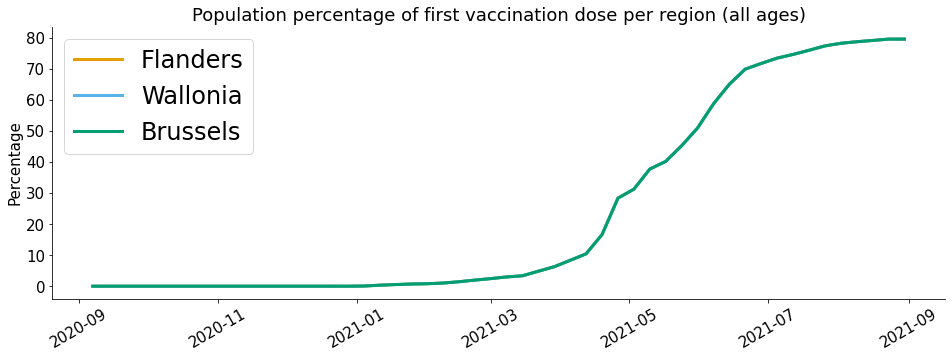

In [166]:
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg=agg)

inhabitants = pd.read_csv('../../data/raw/GIS/inhabitants.csv')
pop_flanders = inhabitants[inhabitants['NIS']==2000]['inhabitants'].values[0]
pop_wallonia = inhabitants[inhabitants['NIS']==3000]['inhabitants'].values[0]
pop_brussels = inhabitants[inhabitants['NIS']==4000]['inhabitants'].values[0]

public_spatial_vaccination_data_like_flanders = public_spatial_vaccination_data.copy()
for type_of_data in ['CUMULATIVE', 'INCIDENCE']:
    sum_of_data = public_spatial_vaccination_data[type_of_data].loc[:,10000,:].values + \
                  public_spatial_vaccination_data[type_of_data].loc[:,20001,:].values + \
                  public_spatial_vaccination_data[type_of_data].loc[:,30000,:].values + \
                  public_spatial_vaccination_data[type_of_data].loc[:,40000,:].values + \
                  public_spatial_vaccination_data[type_of_data].loc[:,70000,:].values
    for nis in [10000, 20001, 20002, 21000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]:
        public_spatial_vaccination_data_like_flanders[type_of_data].loc[:,nis,:] = \
            sum_of_data / \
            inhabitants[inhabitants['NIS']==2000]['inhabitants'].values[0] * \
            inhabitants[inhabitants['NIS']==nis]['inhabitants'].values[0]

dates_vacc = pd.date_range(start = '2020-09-01', end = '2021-09-01', freq='W-MON')
vaccs_prov=[]

vaccination_function = make_vaccination_function(public_spatial_vaccination_data_like_flanders, spatial=True)
sciensano_spatial_first_dose = vaccination_function.get_sciensano_spatial_first_dose
for date in dates_vacc:
    vacc_prov = sciensano_spatial_first_dose(date).sum(axis=1)
    vaccs_prov.append(vacc_prov)
vaccs_prov=np.array(vaccs_prov).cumsum(axis=0)

# Visualise vaccination degree per region (wallonia, Flanders, Brussels)

inhabitants = pd.read_csv('../../data/raw/GIS/inhabitants.csv')
pop_flanders = inhabitants[inhabitants['NIS']==2000]['inhabitants'].values[0]
pop_wallonia = inhabitants[inhabitants['NIS']==3000]['inhabitants'].values[0]
pop_brussels = inhabitants[inhabitants['NIS']==4000]['inhabitants'].values[0]

vaccs_flanders = vaccs_prov[:,0] + vaccs_prov[:,1] + vaccs_prov[:,4] + vaccs_prov[:,5] + vaccs_prov[:,8]
vaccs_wallonia = vaccs_prov[:,2] + vaccs_prov[:,6] + vaccs_prov[:,7] + vaccs_prov[:,9] + vaccs_prov[:,10]
vaccs_brussels = vaccs_prov[:,3]

rel_vaccs_flanders = (vaccs_flanders / pop_flanders)*100
rel_vaccs_wallonia = (vaccs_wallonia / pop_wallonia)*100
rel_vaccs_brussels = (vaccs_brussels / pop_brussels)*100

fig, ax = plt.subplots(figsize=(16,5))
ax.grid(False)
labels = ['Flanders', 'Wallonia', 'Brussels']
ax.plot(dates_vacc, rel_vaccs_flanders, label=labels[0])
ax.plot(dates_vacc, rel_vaccs_wallonia ,label=labels[1])
ax.plot(dates_vacc, rel_vaccs_brussels ,label=labels[2])
ax.legend(loc='upper left', fontsize=24)
ax.tick_params('x', labelrotation=30)
ax.set_title('Population percentage of first vaccination dose per region (all ages)')
ax.set_ylabel('Percentage')

# plt.savefig('relative-vaccination-per-region.png', dpi=400, bbox_inches='tight')

In [225]:
# Model set-up

params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)
full_relaxation = False # relaxation is a thing of the past (pre-summer 2021)

# Time-dependent social contact of policies_all
params.update({'l1' : 5,
               'l2' : 6,
               'prev_schools' : 0,
               'prev_work' : .5,
               'prev_rest_lockdown' : .5,
               'prev_rest_relaxation' : 5,
               'prev_home' : .5}) # This is no longer very valid is it?

# time-dependent vaccination
params.update({'initN' : initN,
               'daily_first_dose' : 60000, # copy default values from vaccination_function, which are curently not used I think
               'delay_immunity' : 14,
               'vacc_order' : [8, 7, 6, 5, 4, 3, 2, 1, 0],
               'stop_idx' : 9,
               'refusal' : [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]})

# time-dependent seasonality
params.update({'season_factor' : 1,
               'amplitude' : 0.1,
               'peak_shift' : 0})

# Update standard transmission coefficients
params.update({'beta_R' : 0.011,
               'beta_U' : 0.011,
               'beta_M' : 0.013})

model_real = models.COVID19_SEIRD_spatial_vacc(initial_states_prov_sept, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policies_all, 
                                                   'N_vacc' : vaccination_function, 
                                                   'alpha' : VOC_function, #})
                                                   'season_factor' : seasonality})

vaccination_function_like_bxl = make_vaccination_function(public_spatial_vaccination_data_like_bxl, spatial=True)
model_bxl = models.COVID19_SEIRD_spatial_vacc(initial_states_prov_sept, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policies_all, 
                                                   'N_vacc' : vaccination_function_like_bxl, 
                                                   'alpha' : VOC_function, #})
                                                   'season_factor' : seasonality})

vaccination_function_like_flanders = make_vaccination_function(public_spatial_vaccination_data_like_flanders, spatial=True)
model_flanders = models.COVID19_SEIRD_spatial_vacc(initial_states_prov_sept, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policies_all, 
                                                   'N_vacc' : vaccination_function_like_flanders, 
                                                   'alpha' : VOC_function, #})
                                                   'season_factor' : seasonality})

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:264: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_start = pd.Timestamp(df['INCIDENCE'].ne(0).idxmax()[0], freq='D')
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:265: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_end = pd.Timestamp(df.index[-1][0], freq='D')


In [226]:
warmup = 0
start_sim = '2021-01-01' # Date of initial conditions
end_sim = '2021-11-01'

out_real = model_real.sim(end_sim,start_date=start_sim,warmup=warmup)
out_bxl = model_bxl.sim(end_sim, start_date=start_sim, warmup=warmup)
out_flanders = model_flanders.sim(end_sim,start_date=start_sim, warmup=warmup)

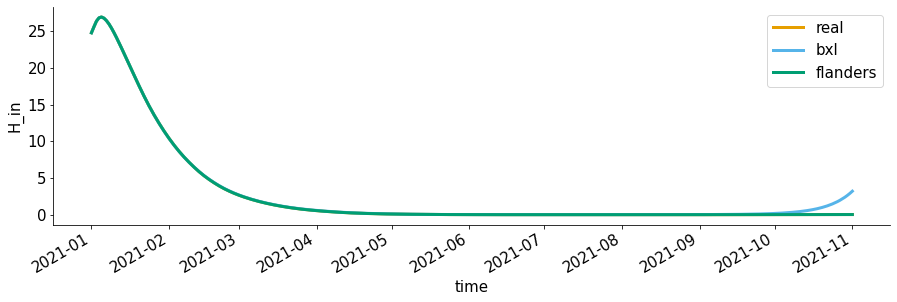

In [227]:
fix,ax=plt.subplots(figsize=(15,4))

out_real['H_in'].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='real')
out_bxl['H_in'].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='bxl')
out_flanders['H_in'].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='flanders')
ax.grid(False)
ax.legend()

# Last-minute prediction from 2020

In [44]:
# Model initial condition on August 27th

# Problem! These are the initial states for arrondissements.
# We are only interested in provinces for now, so we need to **aggregate**

##############################
# STARTING IN SEPTEMBER 2020 #
##############################

# partial

init_states_name = 'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_2020-08-27_full-manual-fix.json'
with open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{init_states_name}', 'r') as fp:
    initial_states = json.load(fp)

initial_states_prov_sept = dict()
for key in initial_states:
    initial_states_prov_sept[key] = np.zeros([11,9])
    initial_states_prov_sept[key][0] = np.array(initial_states[key][0:3]).sum(axis=0) # 1000 Antwerp
    initial_states_prov_sept[key][1] = np.array(initial_states[key][4:6]).sum(axis=0) # 20001 Vlaams-Brabant
    initial_states_prov_sept[key][2] = np.array(initial_states[key][6]) # 20002 Waals-Brabant
    initial_states_prov_sept[key][3] = np.array(initial_states[key][3]) # 21000 Brussel
    initial_states_prov_sept[key][4] = np.array(initial_states[key][7:15]).sum(axis=0) # 30000 West-Vlaanderen
    initial_states_prov_sept[key][5] = np.array(initial_states[key][15:21]).sum(axis=0) # 40000 Oost-Vlaanderen
    initial_states_prov_sept[key][6] = np.array(initial_states[key][21:28]).sum(axis=0) # 50000 Hainaut
    initial_states_prov_sept[key][7] = np.array(initial_states[key][28:33]).sum(axis=0) # 60000 Liege
    initial_states_prov_sept[key][8] = np.array(initial_states[key][33:36]).sum(axis=0) # 70000 Limburg
    initial_states_prov_sept[key][9] = np.array(initial_states[key][36:41]).sum(axis=0) # 80000 Luxembourg
    initial_states_prov_sept[key][10] = np.array(initial_states[key][41:]).sum(axis=0) # 90000 

# Add empty entries for vaccination states
vacc_states = ['S_v', 'E_v', 'I_v', 'A_v', 'M_v', 'C_v', 'C_icurec_v', 'ICU_v', 'R_v']
for state in vacc_states:
    initial_states_prov_sept[state]=np.zeros([11, 9])
    
    
##########################
# STARTING IN MARCH 2020 #
##########################

# complete

age=40
dist='frac'
init_number = 3 # if warmup = 54 and start_date = 2020-03-05
initE = initial_state(dist='frac', agg=agg, age=age, number=init_number) # 40-somethings dropped in Brussels (arrival by plane)
initial_states_prov_march = {'S': initN, 'E': initE}

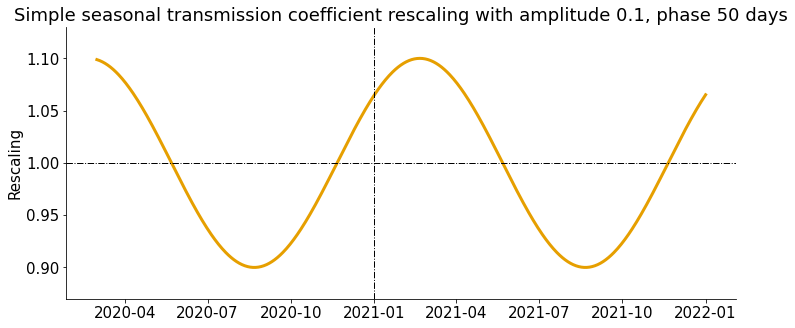

In [45]:
# Add definition of function that controls seasonality


dates = pd.date_range(start = '2020-03-01', end = '2022-01-01', freq='D')
ref_date = pd.to_datetime('2021-01-01')

# Note that this definition is different from Tijs's definition of seasonality
def seasonality(t, states, param, amplitude, peak_shift):
    # If peak_shift = 0, the max is on the first of January
    maxdate = pd.Timedelta(days=peak_shift) + ref_date
    # One period is one year long (seasonality)
    t = (t - pd.to_datetime(maxdate))/pd.Timedelta(days=1)/365
    return 1+amplitude*np.cos( 2*np.pi*(t))


season_effects = []
amplitude = 0.1
peak_shift = 50 # days
for date in dates:
    season_effect = seasonality(date, {}, {}, amplitude, peak_shift)
    season_effects.append(season_effect)
    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, season_effects)
ax.grid(False)
ax.set_ylim([0.87, 1.13])
ax.set_ylabel('Rescaling')
ax.axhline(1, color='k', linewidth=1, linestyle='-.')
ax.axvline(ref_date, color='k', linewidth=1, linestyle='-.')
title=ax.set_title(f'Simple seasonal transmission coefficient rescaling with amplitude {amplitude}, phase {peak_shift} days')

# plt.savefig('seasonal_transmission_rescaling.png', dpi=400, bbox_inches='tight')

In [47]:
# Model set-up

params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)
full_relaxation = False # relaxation is a thing of the past (pre-summer 2021)

# Time-dependent social contact: FULL RELAXATION
if full_relaxation:
    params.update({'l1' : 4,
                   'l2' : 6,
                   'l_relax' : 20,
                   'prev_schools' : 0,
                   'prev_work' : .5,
                   'prev_rest' : .5,
                   'prev_home' : .5,
                   'relaxdate' : '2021-06-01'}) # This is no longer very valid is it?
else:
    params.update({'l1' : 4,
                   'l2' : 6,
                   'prev_schools' : 0,
                   'prev_work' : .5,
                   'prev_rest_lockdown' : .5,
                   'prev_rest_relaxation' : .5,
                   'prev_home' : .5})
    
# time-dependent vaccination
params.update({'initN' : initN,
               'daily_first_dose' : 60000, # copy default values from vaccination_function, which are curently not used I think
               'delay_immunity' : 14,
               'vacc_order' : [8, 7, 6, 5, 4, 3, 2, 1, 0],
               'stop_idx' : 9,
               'refusal' : [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]})

# time-dependent seasonality
params.update({'season_factor' : 1,
               'amplitude' : 0.1,
               'peak_shift' : 0})

# Update standard transmission coefficients
params.update({'beta_R' : 0.019,
               'beta_U' : 0.019,
               'beta_M' : 0.019})

model = models.COVID19_SEIRD_spatial_vacc(initial_states_prov_march, params, spatial=agg,
                        time_dependent_parameters={'Nc' : policies_all, 
                                                   'N_vacc' : vaccination_function, 
                                                   'alpha' : VOC_function, #})
                                                   'season_factor' : seasonality})

In [50]:
# json_name = 'arr_WAVE1-FULL_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10.json'
# json_loc = f"../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr"

# samples_dict = json.load(open(f'{json_loc}/{json_name}'))
# parNames_mcmc = ['beta_R', 'beta_U', 'beta_M', 'l', 'prev_work', 'prev_rest', 'prev_home']

# samples_dict.keys()

start_sim = samples_dict['start_date_FULL']
end_sim = '2022-01-01'
warmup = samples_dict['warmup']
n_samples = 1

samples_dict_prediction = dict({})
for key in ['l', 'prev_work', 'prev_rest', 'prev_home']:
    samples_dict_prediction[key] = samples_dict[key]
for key in ['beta_R', 'beta_U', 'beta_M']:
    samples_dict_prediction[key] = samples_dict[key]

def draw_fcn(param_dict,samples_dict):
    # pick one random value from the dictionary
    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    # take out the other parameters that belong to the same iteration
    param_dict['beta_U'] = samples_dict['beta_U'][idx]
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    param_dict['l'] = samples_dict['l'][idx]
    param_dict['prev_home'] = samples_dict['prev_home'][idx]
    param_dict['prev_work'] = samples_dict['prev_work'][idx]
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
    return param_dict

out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict_prediction, verbose=True)

TypeError: integrate() takes 62 positional arguments but 64 were given

In [22]:
params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)
params.keys()

dict_keys(['Nc', 'h', 'c', 'm_C', 'm_ICU', 'dc_R', 'dc_D', 'dICU_R', 'dICU_D', 'dICUrec', 'a', 's', 'N_vacc', 'e_s', 'e_h', 'e_a', 'e_i', 'd_vacc', 'place', 'area', 'p', 'sg', 'xi', 'da', 'dm', 'dhospital', 'sigma', 'omega', 'zeta', 'beta_R', 'beta_U', 'beta_M', 'alpha', 'K_inf1', 'K_inf2', 'K_hosp'])